### Your name:

Joan Soo Li Lim

### Collaborators:

None

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### TensorFlow

Q1. When is a variable initialized? When is it destroyed?

A variable x starts its life when its initializer is run in the session (x.initializer) and it is destroyed when the session is subsequently closed. Initialization can also occur globally by creating an init node first (init = tf.global_variables_initializer()) and then explicitly initializing all the variables in the session (init.run()).

Q2. What is the difference between a placeholder and a variable?

1. Placeholders hold information about the type and shape of the tensor they represent, but they have no value and don't actually perform any computation.  The feed_dict argument to a placeholder must be used to feed training or test data to Tensorflow in order to evaluate an operation during the execution phase. Placeholders can also be used to pass or change a value in the assignment node of a variable.

2. Variables in contrast holds a value that can be used in performing computations during training (like weights or bias) or to store the model's parameters. A variable must be initalized with a value in order to run it for computational purposes. A variable's value can subsequently be changed (assignment) and returned (run) or shared. Variables are stateful and can also be restored if it has been saved in a summary.

Q3. How many times does reverse-mode autodiff need to traverse the graph in order to compute the gradients of the cost function with regards to 10 variables? What about forward-mode autodiff? And symbolic differentiation?

Assuming that the question implies 10 INPUT variables and 1 output variable, then the number of graph transversals qccording to table 9.2 in the text:

1. Reverse mode autodiff -> n_output + 1 = 2 (one transversal forward and another backward, regardless of number of inputs)
2. Forward-mode autodiff -> n_input = 10 (one transversal per input)
3. Symbolic differentiation -> N/A (builds a new gradient graph and does not transverse the original graph)

Q4. Implement Logistic Regression with Mini-batch Gradient Descent using TensorFlow. Train it and evaluate it on the moons dataset (introduced in Chapter 5). Try adding all the bells and whistles:

- Define the graph within a logistic_regression() function that can be reused easily.

- Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.

- Restore the last checkpoint upon startup if training was interrupted.

- Define the graph using name scopes so the graph looks good in TensorBoard.

- Add summaries to visualize the learning curves in TensorBoard.

- Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

In [2]:
#### More setup ####

#### Disclaimer: I followed the code from Module 9, with some modifications as I learnt along the way. ####

# To make this notebook's output stable across runs
def reset_graph(seed=123):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "A7tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
import warnings
warnings.simplefilter("ignore")

In [3]:
# Create the moons dataset. Try 10000 samples with noise = 0.10. 
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(n_samples=10000, noise=0.1, random_state=123)
m, n = Xmoon.shape

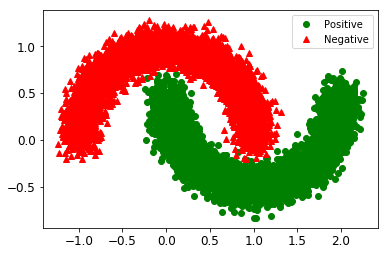

In [4]:
# Visualize moons
plt.plot(Xmoon[ymoon == 1, 0], Xmoon[ymoon == 1, 1], 'go', label="Positive")
plt.plot(Xmoon[ymoon == 0, 0], Xmoon[ymoon == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [5]:
# Add bias to moons
Xmoon_bias = np.c_[np.ones((m, 1)), Xmoon]
Xmoon_bias[:5]

array([[ 1.        , -0.06637413,  0.98348655],
       [ 1.        ,  0.84875329,  0.36312269],
       [ 1.        ,  2.0450319 ,  0.14017863],
       [ 1.        ,  0.92733527,  0.09326818],
       [ 1.        , -0.84412515,  0.54820898]])

In [6]:
# Y Reshape to column vector
ymoon_col = ymoon.reshape(-1, 1)
ymoon_col[:5]

array([[0],
       [0],
       [1],
       [0],
       [0]])

In [7]:
# Create training and test sets. Randomizing a batch will occur later.
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = Xmoon_bias[:-test_size]
X_test = Xmoon_bias[-test_size:]
y_train = ymoon_col[:-test_size]
y_test = ymoon_col[-test_size:]

In [8]:
# Fetch random batches of size batch_size. 
# Note, we won't use epoch and an index might be seen again in later batches.
def random_batch(X_train, y_train, batch_size):
    indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    return X_batch, y_batch

In [9]:
# Just testing batches returned
X_batch, y_batch = random_batch(X_train, y_train, 5)
print ("X_batch\n", X_batch)
print ("\ny_batch\n", y_batch)

X_batch
 [[ 1.          1.24577918 -0.50284435]
 [ 1.          0.79262936  0.14706293]
 [ 1.         -0.57857673  0.9039443 ]
 [ 1.          1.34624612 -0.62488558]
 [ 1.         -0.97348186  0.11782999]]

y_batch
 [[1]
 [0]
 [0]
 [1]
 [0]]


## Build the model

From text (CHAPTER 4): 

p̂ =hθ(x)=σ(θT⋅x), where θT is the transpose of the parameter vector, which contains the bias term θ0 and the weights θi. The input vector x contains a constant term x0=1, as well as all the input features xi. NOTE: 1 <= i <= n

To generalize this to the whole training set, we can let X represent the matrix of the data set where each ith row in X is the transpose of the input xi from the data set. The equation then becomes p^=σ(X⋅θ).

In [10]:
### Build the (simple) model to test out Tensorflow ###

n_inputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

# Setup the variable and nodes to compute sigmoid of logits and respective log loss
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=123), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = tf.sigmoid(logits)
loss = tf.losses.log_loss(y, y_proba)

# Hyperparameter learning rate setup and optimized for loss through gradient descent
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [11]:
# Initalize
init = tf.global_variables_initializer()

In [12]:
# Train and evaluate test set
n_epochs = 1001
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            
            # Get the batches for the current training run
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        # Evaluate the test log loss after training for this epoch    
        loss_val = loss.eval({X: X_test, y: y_test})
        
        # Output current loss for each 100th epoch
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    # Evaluate the probabilities (sigmoid of logits and theta) for the test set        
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.69560534
Epoch: 100 	Loss: 0.2523085
Epoch: 200 	Loss: 0.24427477
Epoch: 300 	Loss: 0.24264917
Epoch: 400 	Loss: 0.24228391
Epoch: 500 	Loss: 0.24217817
Epoch: 600 	Loss: 0.24209365
Epoch: 700 	Loss: 0.24216862
Epoch: 800 	Loss: 0.24209683
Epoch: 900 	Loss: 0.24207467
Epoch: 1000 	Loss: 0.24215524


In [13]:
# Try p >= .50 for belonging in the positive set and look at output
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[False],
       [ True],
       [False],
       [False],
       [ True]])

In [14]:
# Compare precision vs recall scores
from sklearn.metrics import precision_score, recall_score

print (precision_score(y_test, y_pred))
print (recall_score(y_test, y_pred))

0.8821782178217822
0.9


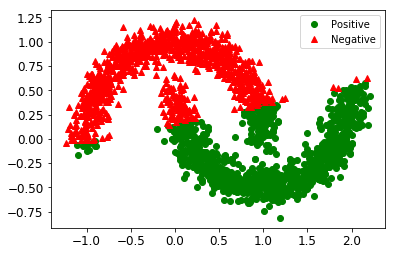

In [15]:
# Plot the output. 
# Revert y back to a 1D array. Also, recall that X_test contains the bias column at index 0. Plot X_test.
y_pred_idx = y_pred.reshape(-1) 
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [16]:
# As noted, there is a linear boundary. Consider adding more features to capture the moon shapes. 
# Start from Xmoons and use the bias feature from Polynomial Features with degree 3. Leave all new features in.
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 3, interaction_only = False, include_bias = True)
Xmoon_enhanced = poly.fit_transform(Xmoon) 
print ("XMoon\n", Xmoon[:5])
print ("\nXMoon_enhanced\n",Xmoon_enhanced[:5])

XMoon
 [[-0.06637413  0.98348655]
 [ 0.84875329  0.36312269]
 [ 2.0450319   0.14017863]
 [ 0.92733527  0.09326818]
 [-0.84412515  0.54820898]]

XMoon_enhanced
 [[ 1.00000000e+00 -6.63741339e-02  9.83486555e-01  4.40552565e-03
  -6.52780683e-02  9.67245803e-01 -2.92412949e-04  4.33277524e-03
  -6.42001025e-02  9.51273243e-01]
 [ 1.00000000e+00  8.48753290e-01  3.63122691e-01  7.20382148e-01
   3.08201579e-01  1.31858089e-01  6.11426718e-01  2.61587104e-01
   1.11914987e-01  4.78806640e-02]
 [ 1.00000000e+00  2.04503190e+00  1.40178634e-01  4.18215549e+00
   2.86669780e-01  1.96500495e-02  8.55264140e+00  5.86248845e-01
   4.01849782e-02  2.75451711e-03]
 [ 1.00000000e+00  9.27335268e-01  9.32681780e-02  8.59950700e-01
   8.64908709e-02  8.69895304e-03  7.97462613e-01  8.02060350e-02
   8.06684595e-03  8.11335501e-04]
 [ 1.00000000e+00 -8.44125147e-01  5.48208979e-01  7.12547264e-01
  -4.62756985e-01  3.00533084e-01 -6.01479064e-01  3.90624808e-01
  -2.53687534e-01  1.64754935e-01]]


In [17]:
# Create new training and test sets. 
X_train_enhanced = Xmoon_enhanced[:-test_size]
X_test_enhanced = Xmoon_enhanced[-test_size:]
print (X_train_enhanced.shape)
print (X_test_enhanced.shape)

(8000, 10)
(2000, 10)


In [18]:
# Build the (bells and whistles) model now
def logistic_regression(X, y, initializer=None, seed=123, learning_rate=0.01):
    
    n_inputs_including_bias = int(X.get_shape()[1])
    
    with tf.name_scope("logistic_regression"):
        
        # Set model's sigmoid function and respective parameters
        with tf.name_scope("model"): 
            # Only initalize theta value if there isn't an initializer. 
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        
        # Set model's training gradient optimizer and respective log loss function
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        
        # Set tf's global intializer. This is OK as the model's variable initialization is not order-dependant. 
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        
        # Set saver to save current state of tf.
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    
    return y_proba, loss, training_op, loss_summary, init, saver

In [19]:
# Accomodate Tensorboard by creating the log directory to store graph summaries at different checkpoints
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [20]:
# Start fresh
reset_graph()

In [21]:
### Set up Tensorflow ###

# Note we have 9 features now (excluding bias) due to call to PolynomialFeatures.
n_inputs = 9
logdir = log_dir("logreg")

# Placeholders for input
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

# Call on logistic_regression
y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

# Save graph summaries
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [22]:
### Run the new model, saving at checkpoints as necessary to allow for restoration of model. ###

n_epochs = 10001
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    
    # If the checkpoint file exists, restore the model and load the epoch number.
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
   
    # Otherwise, start with a fresh session and initalize all variables.
    else:
        start_epoch = 0
        sess.run(init)

    # Iterate through each epoch 
    for epoch in range(start_epoch, n_epochs):
        
        # Get batches based on batch_size and feed into training model
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        # Feed the test data and get the loss and sumaries. Store the summaries for Tensorboard.
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        
        # For each 500th epoch, output the current loss and store the session information for this checkpoint.
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    # Save the final model and get the probabilities for the test data.            
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.8637506
Epoch: 500 	Loss: 0.057388052
Epoch: 1000 	Loss: 0.03707914
Epoch: 1500 	Loss: 0.028664928
Epoch: 2000 	Loss: 0.023912344
Epoch: 2500 	Loss: 0.02079567
Epoch: 3000 	Loss: 0.018564522
Epoch: 3500 	Loss: 0.016889665
Epoch: 4000 	Loss: 0.015570252
Epoch: 4500 	Loss: 0.014499856
Epoch: 5000 	Loss: 0.013612263
Epoch: 5500 	Loss: 0.012862952
Epoch: 6000 	Loss: 0.012217342
Epoch: 6500 	Loss: 0.011656191
Epoch: 7000 	Loss: 0.011166243
Epoch: 7500 	Loss: 0.0107258195
Epoch: 8000 	Loss: 0.010335342
Epoch: 8500 	Loss: 0.009981688
Epoch: 9000 	Loss: 0.009662809
Epoch: 9500 	Loss: 0.009374828
Epoch: 10000 	Loss: 0.009110903


In [23]:
# Compare precision vs recall scores for the prediction value at p >= 0.5 for the positive moon.
y_pred = (y_proba_val >= 0.5)

print (precision_score(y_test, y_pred))
print (recall_score(y_test, y_pred))

0.9989909182643795
1.0


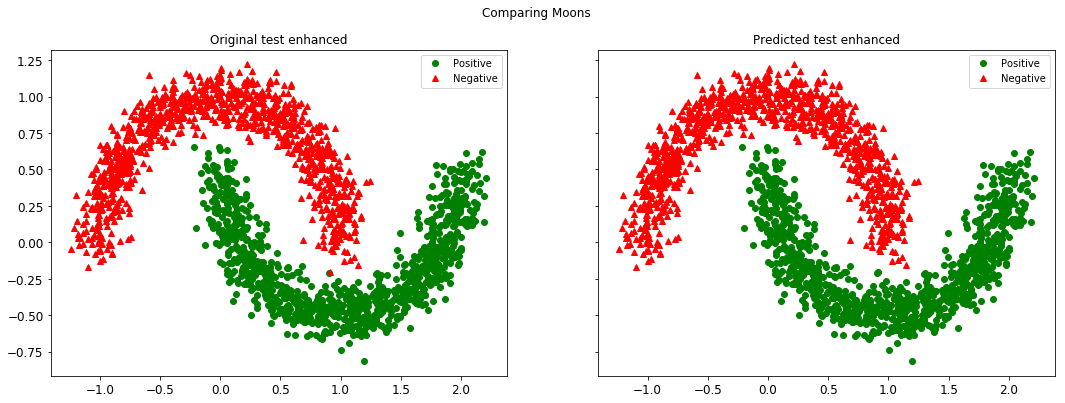

In [24]:
# Plot X_test_enhanced for original and predicted. 
# Revert y back to a 1D array. Also, recall that X_test_enhanced contains the bias column at index 0. 
y_pred_idx = y_pred.reshape(-1) 
y_test_idx = (y_test == 1).reshape(-1) 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw = {'width_ratios':[3, 3]}, figsize=(18, 6))
f.suptitle('Comparing Moons')
ax1.plot(X_test_enhanced[y_test_idx, 1], X_test_enhanced[y_test_idx, 2], 'go', label="Positive")
ax1.plot(X_test_enhanced[~y_test_idx, 1], X_test_enhanced[~y_test_idx, 2], 'r^', label="Negative")
ax2.plot(X_test_enhanced[y_pred_idx, 1], X_test_enhanced[y_pred_idx, 2], 'go', label="Positive")
ax2.plot(X_test_enhanced[~y_pred_idx, 1], X_test_enhanced[~y_pred_idx, 2], 'r^', label="Negative")
ax1.title.set_text('Original test enhanced')
ax2.title.set_text('Predicted test enhanced')
ax1.legend()
ax2.legend()
f.show()

Note that the model is better due to the addition of features. However, we are still not able to differentiate positive / negative on the area of where the original plot overlaps (touches each other) in the middle of the curves.

In [25]:
### Now, extend the (bell and whistles) model to tune the learning rate and number of batches.  ###

from scipy.stats import reciprocal

# Due to time constraints, set each run at 5 iterations. 
n_search_iterations = 5  

for search_iteration in range(n_search_iterations):
    
    # Randomly pick batch size and learning rate 
    batch_size = np.random.randint(10, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    n_inputs = 9
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    # Start fresh
    reset_graph()

    ##  Everything set up the same as the last model run except for checkpoint saving (see below) ##
    
    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            
            # Instead of outputting the loss for each 100th epoch, we simply add a '.' to indicate that the program
            # is still running at each 500th epoch. We do not save checkpoints here for simplicity's sake and also to save
            # hard drive space on my Mac.
            if epoch % 500 == 0:
                print(".", end="")

        # Only save final model for restoration later, as needed
        saver.save(sess, final_model_path)
       
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        print("\n  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))

Iteration 0
  logdir: tf_logs/logreg-run-20180728143538/
  batch size: 19
  learning_rate: 0.004430375245218265
  training: .....................
  precision: 0.9989909182643795
  recall: 1.0
Iteration 1
  logdir: tf_logs/logreg-run-20180728150614/
  batch size: 43
  learning_rate: 0.0017826497151386947
  training: .....................
  precision: 0.9979838709677419
  recall: 1.0
Iteration 2
  logdir: tf_logs/logreg-run-20180728151929/
  batch size: 26
  learning_rate: 0.00203228544324115
  training: .....................
  precision: 0.9979838709677419
  recall: 1.0
Iteration 3
  logdir: tf_logs/logreg-run-20180728154109/
  batch size: 76
  learning_rate: 0.004491523825137997
  training: .....................
  precision: 0.9979838709677419
  recall: 1.0
Iteration 4
  logdir: tf_logs/logreg-run-20180728154844/
  batch size: 84
  learning_rate: 0.07963234721775589
  training: .....................
  precision: 0.9989909182643795
  recall: 1.0


In [26]:
file_writer.close()

Based on tensorboard learning curve image (submitted as 'tensorboard.png'), the learning curve for 'logreg-run-20180728154844' of iteration 4 indicates that the model learnt fairly quickly (fast drop) and has the lowest log loss for all the runs done on July 28. It's batch size was 84 and the learning rate was 0.07963 approx. 

Note that the run 'logreg-run-20180728142909' occurred as the first (bells and whistles) model prior to tuning. For that run, the batch size was 100 and the learning rate was 0.01 (default).

In [27]:
# Restore model from iteration 4. 
with tf.Session() as sess:
    saver.restore(sess, "./my_logreg_model_4")
    
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    

INFO:tensorflow:Restoring parameters from ./my_logreg_model_4


In [28]:
# Verify this is the right one by comparing values to above output
y_pred = (y_proba_val >= 0.5)
print("\n  precision:", precision_score(y_test, y_pred))
print("  recall:", recall_score(y_test, y_pred))


  precision: 0.9989909182643795
  recall: 1.0


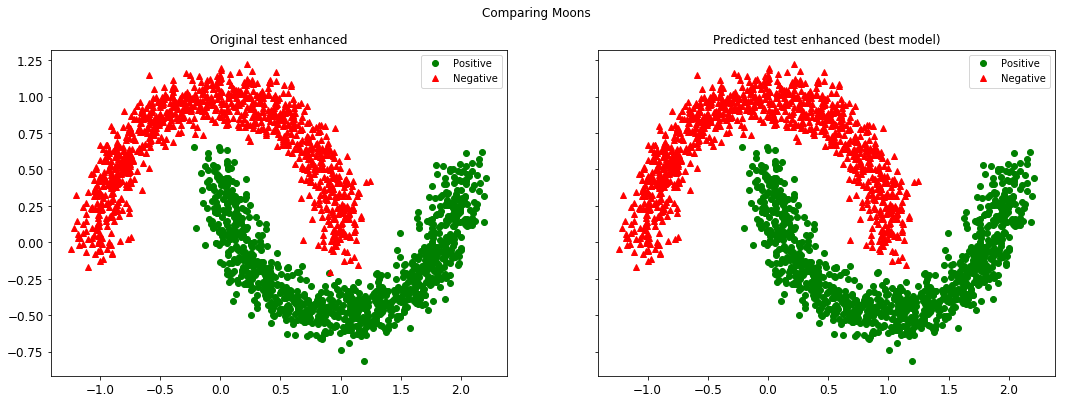

In [29]:
# Plot X_test_enhanced for original and predicted. 
# Revert y back to a 1D array. Also, recall that X_test_enhanced contains the bias column at index 0. 
y_pred_idx = y_pred.reshape(-1) 
y_test_idx = (y_test == 1).reshape(-1) 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw = {'width_ratios':[3, 3]}, figsize=(18, 6))
f.suptitle('Comparing Moons')
ax1.plot(X_test_enhanced[y_test_idx, 1], X_test_enhanced[y_test_idx, 2], 'go', label="Positive")
ax1.plot(X_test_enhanced[~y_test_idx, 1], X_test_enhanced[~y_test_idx, 2], 'r^', label="Negative")
ax2.plot(X_test_enhanced[y_pred_idx, 1], X_test_enhanced[y_pred_idx, 2], 'go', label="Positive")
ax2.plot(X_test_enhanced[~y_pred_idx, 1], X_test_enhanced[~y_pred_idx, 2], 'r^', label="Negative")
ax1.title.set_text('Original test enhanced')
ax2.title.set_text('Predicted test enhanced (best model)')
ax1.legend()
ax2.legend()
f.show()

It is interesting to note that the best model's test did not have a far superior (if any) result visually as opposed to the first run prior to tuning for this particular test data set.

In [32]:
sess.close()